# Machine Learning and Additive Manufacturing

Additive manufacturing is the process of building from a computer controlled 3-dimensional printer. The material can be polymer (plastic), ceramic, metallic powder, liquid, or any material that is joined together through deposition, solidification, or fusion. It speeds the development of prototypes by precisely converting a computer aided design (CAD) drawing into a physical device. Additive manufacturing can be either a prototype or scaled up to full product production, but typically for applications that require customization or with low production volumes.

A 3D print data set of additive manufacturing test conditions is available for Polylactic Acid (PLA) and Acrylonitrile Butadiene Styrene (ABS). PLA can print at lower temperatures of 180°C compared to 250°C for ABS. PLA is more brittle than ABS and is not typically suitable for high strength applications. The data was collected by researchers in the Mechanical Engineering department at Selçuk Üniversitesi on a Ultimaker S5 3D printer. The study focused on how the parameters in a specific 3D printer affects the print quality, accuracy and final part strength. This work is based on the settings and PLA or ABS filaments. Material and strength tests were carried out on a Sincotec GMBH tester capable of pulling 20 kN.	

Nine parameters were adjusted for the Ultimaker S5 3D printer.

- Layer Height (mm)
- Wall Thickness (mm)
- Infill Density (%)
- Infill Pattern (Honeycomb or Grid)
- Nozzle Temperature (ºC)
- Bed Temperature (ºC)
- Print Speed (mm/s)
- Material (PLA or ABS)
- Fan Speed (%)

After the part was manufactured, three parameters were measured for each product.

- Roughness (µm)
- Tension Strength (MPa)
- Elongation (%)

The labeled data is a combination of PLA and ABS material, print patterns, and conditions with 66 samples from a first repository and 50 samples from a second repository. There is 70 samples with the duplicates removed and one outlier added. The label associated with each filament is pla or abs. The print pattern is grid or honeycomb.

## Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs

import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import recall_score, roc_auc_score, precision_score, accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import ConfusionMatrixDisplay

from IPython.display import Image

## Import Data

In [3]:
df0 = pd.read_csv("additive_manufacturing.txt")

# Part 1: Data Visualization and Cleansing

## Summary Statistics

In [4]:
df0.head()

layer_height  wall_thickness  infill_density infill_pattern  \
0          0.02             8.0              90           grid   
1          0.02             7.0              90      honeycomb   
2          0.02             1.0              80           grid   
3          0.02             4.0              70      honeycomb   
4          0.02             6.0              90           grid   

   nozzle_temperature  bed_temperature  print_speed material  fan_speed  \
0                 220               60           40      abs          0   
1                 225               65           40      abs         25   
2                 230               70           40      abs         50   
3                 240               75           40      abs         75   
4                 250               80           40      abs        100   

   roughness  tension_strength  elongation  
0         25                18         1.2  
1         32                16         1.4  
2         40                 8         0.8  
3         68                10         0.5  
4         92                 5         0.7

In [5]:
print("shape data frame", df0.shape[0], df0.shape[1])

shape data frame 70 12


In [6]:
df0.describe()

layer_height  wall_thickness  infill_density  nozzle_temperature  \
count     70.000000       70.000000       70.000000           70.000000   
mean       0.097286        5.464286       54.600000          221.785714   
std        0.061971        2.934455       27.926612           14.843037   
min        0.020000        1.000000       10.000000          200.000000   
25%        0.052500        3.000000       32.500000          210.000000   
50%        0.100000        5.500000       50.000000          220.000000   
75%        0.150000        8.000000       80.000000          230.000000   
max        0.200000       12.000000      100.000000          250.000000   

       bed_temperature  print_speed   fan_speed   roughness  tension_strength  \
count        70.000000    70.000000   70.000000   70.000000         70.000000   
mean         73.214286    68.857143   48.614286  155.185714         19.942857   
std          24.197792    45.501803   36.060454   96.070520          9.282812   
min          60.000000    40.000000    0.000000   -1.000000          4.000000   
25%          65.000000    40.000000   25.000000   75.000000         12.000000   
50%          70.000000    60.000000   50.000000  141.000000         18.500000   
75%          75.000000    63.750000   75.000000  218.000000         27.000000   
max         260.000000   360.000000  100.000000  368.000000         38.000000   

       elongation  
count   70.000000  
mean     1.642143  
std      0.756596  
min      0.400000  
25%      1.100000  
50%      1.500000  
75%      2.175000  
max      3.300000

In [7]:
df0.info()
df_infill = df0["infill_pattern"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   layer_height        70 non-null     float64
 1   wall_thickness      70 non-null     float64
 2   infill_density      70 non-null     int64  
 3   infill_pattern      70 non-null     object 
 4   nozzle_temperature  70 non-null     int64  
 5   bed_temperature     70 non-null     int64  
 6   print_speed         70 non-null     int64  
 7   material            70 non-null     object 
 8   fan_speed           70 non-null     int64  
 9   roughness           70 non-null     int64  
 10  tension_strength    70 non-null     int64  
 11  elongation          70 non-null     float64
dtypes: float64(3), int64(7), object(2)
memory usage: 6.7+ KB


Check for balanced classification dataset ('abs' and 'pla' should have about equal amounts)

In [8]:
df0.groupby('material').apply(len)

material
abs    36
pla    34
dtype: int64

<AxesSubplot:>

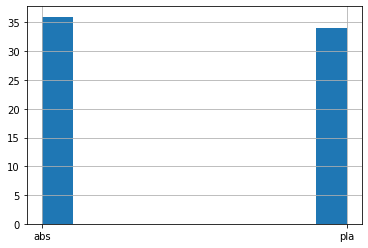

In [9]:
df0["material"].hist()

In [10]:
df0.groupby('infill_pattern').apply(len)

infill_pattern
grid         35
honeycomb    35
dtype: int64

## Data Cleansing

There is one row that contains an outlier. Identify the outlier with boxplots.

<AxesSubplot:>

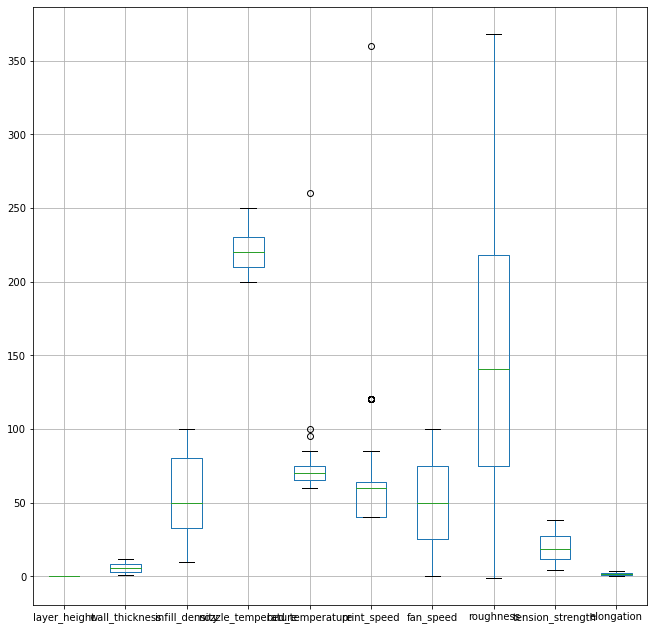

In [11]:
size = (11,11)
df0.boxplot(figsize=size)

<AxesSubplot:xlabel='index', ylabel='roughness'>

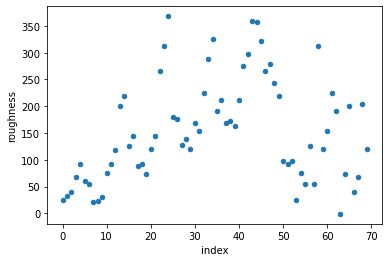

In [12]:
df0.reset_index().plot(kind='scatter', x ='index', y="roughness")

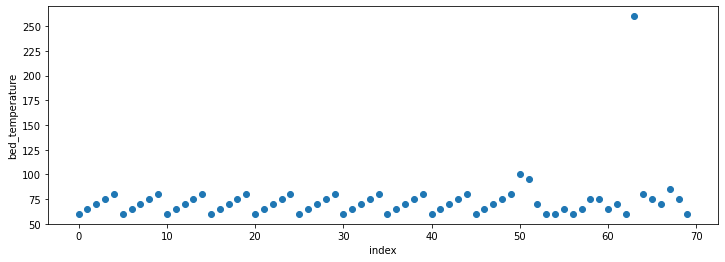

In [13]:
plt.figure(figsize=(12, 4))
plt.scatter(df0.index, df0.bed_temperature)
plt.xlabel("index")
plt.ylabel("bed_temperature")
plt.show()

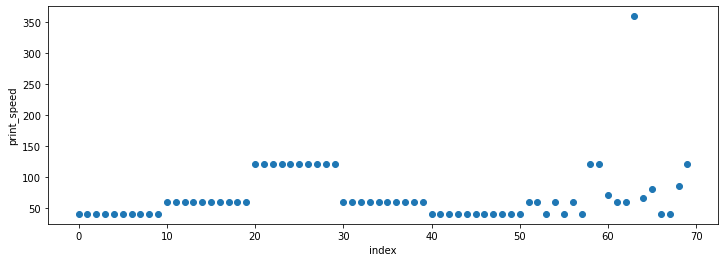

In [14]:
plt.figure(figsize=(12, 4))
plt.scatter(df0.index, df0.print_speed)
plt.xlabel("index")
plt.ylabel("print_speed")
plt.show()

Remove the row that contains the outlier. 

In [15]:
df0 = df0.drop([63])

Verify that the outlier is removed with another plot. Note also that index 63 is slipped.

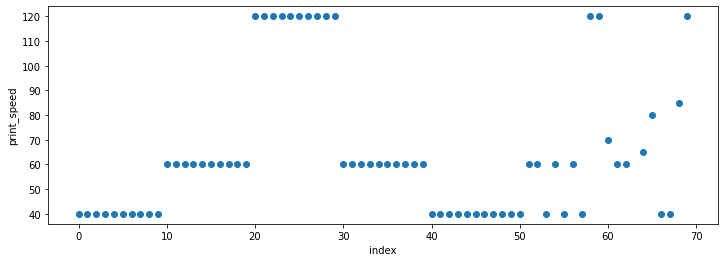

In [16]:

plt.figure(figsize=(12, 4))
plt.scatter(df0.index, df0.print_speed)
plt.xlabel("index")
plt.ylabel("print_speed")
plt.show()

## Exploratory Data



### Data Correlation

Generate a heat map of the data correlation.

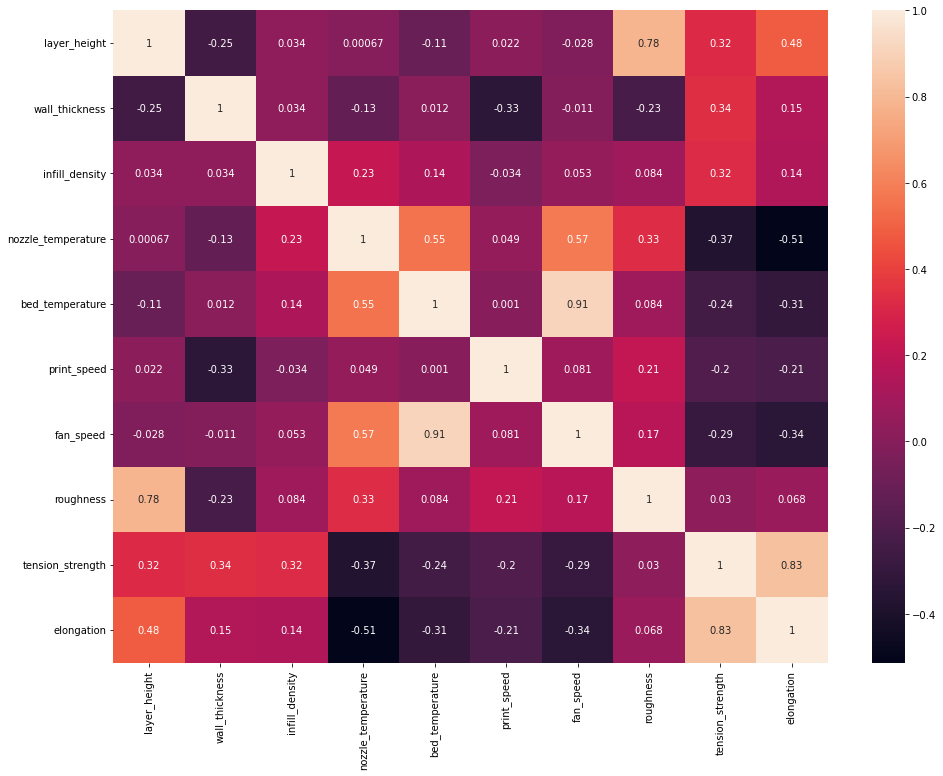

In [17]:
fig, ax = plt.subplots(figsize=(16,12))
XM = df0.copy()
#XM['roughness'] = df0['roughness']
corrMatrix = XM.drop([1,69]).corr()
sns.heatmap(corrMatrix, annot=True)
plt.savefig('corrematrix0.png')

In [18]:
del [[XM]]
df0.columns

Index(['layer_height', 'wall_thickness', 'infill_density', 'infill_pattern',
       'nozzle_temperature', 'bed_temperature', 'print_speed', 'material',
       'fan_speed', 'roughness', 'tension_strength', 'elongation'],
      dtype='object')

### Data Distributions and Pair Plot

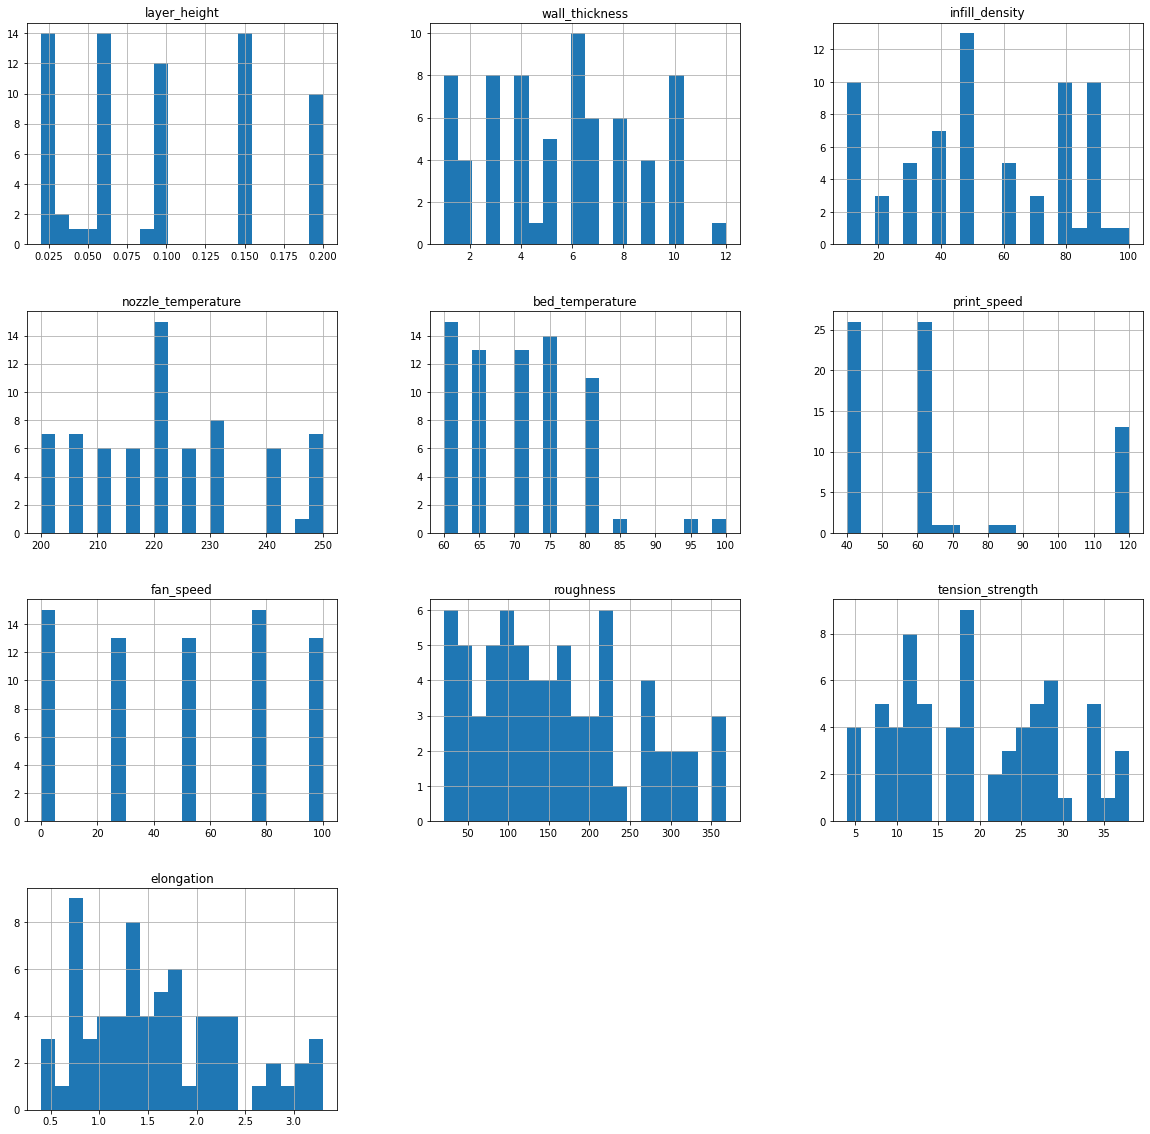

In [19]:
df0.hist(bins=20, figsize=(20,20) )
plt.show()

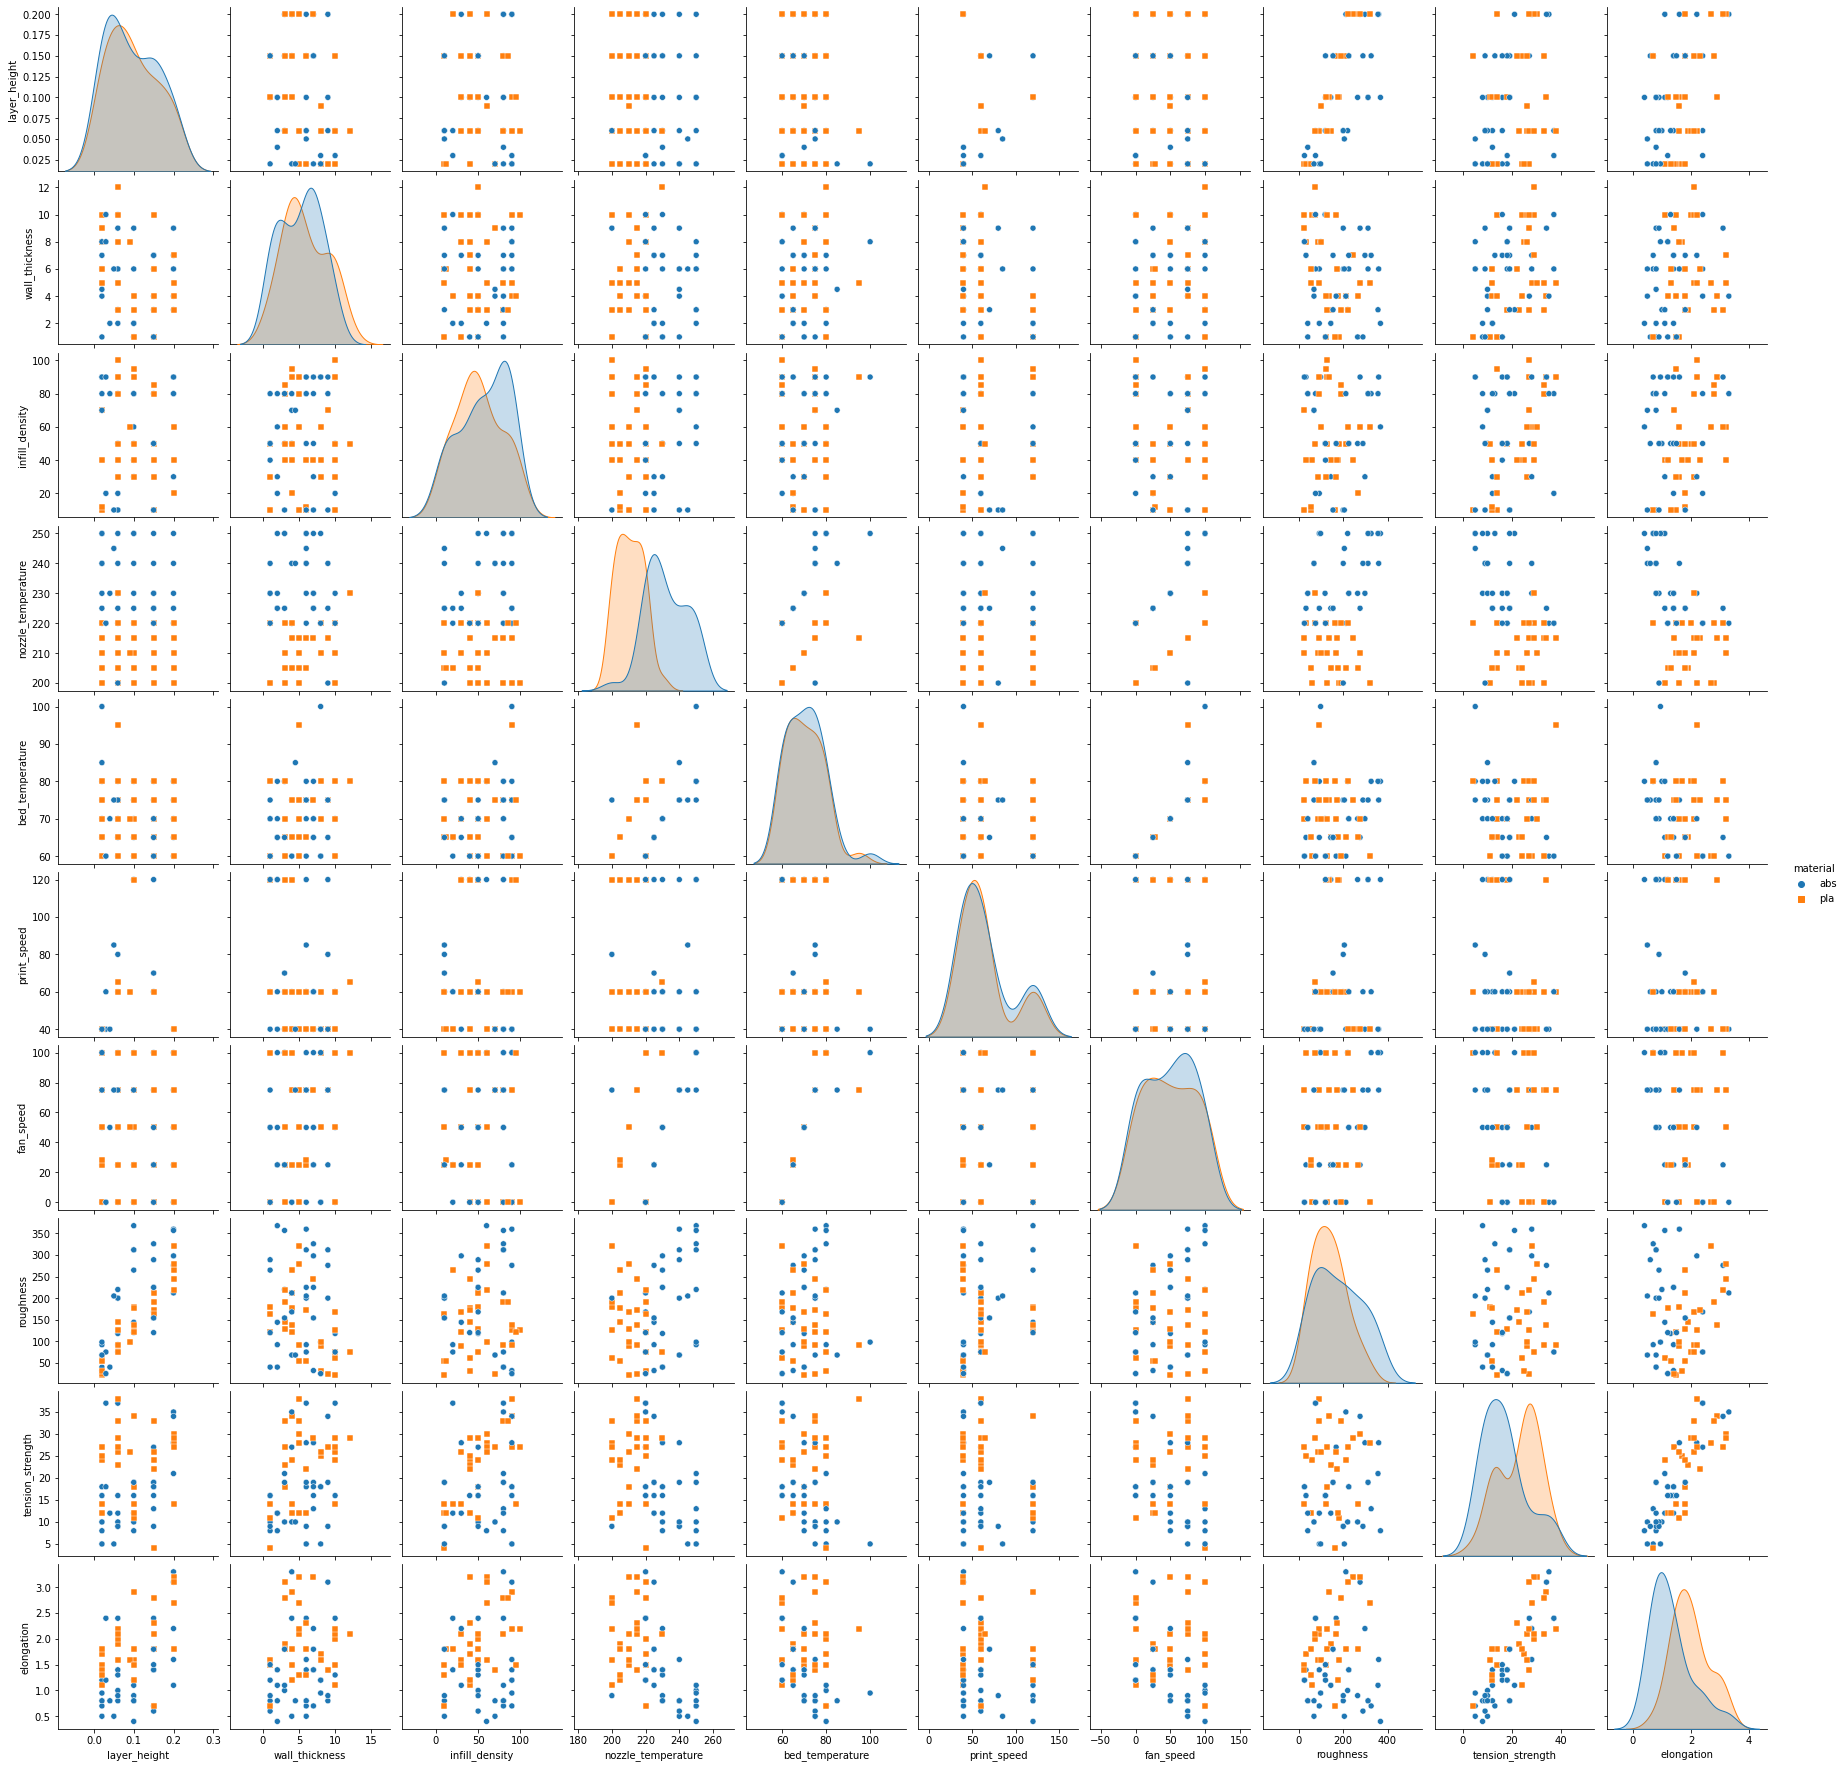

In [20]:
sns.pairplot(df0,  hue="material", markers=["o", "s"])

In [21]:
# sns.pairplot(df0,  hue="infill_pattern", markers=["o", "s"]) 

## Convert String Categories (Text) to Binary (0 or 1)

One-hot encoding translates character labels into a binary representation (0 or 1) for classification. Translate __material__ and __infill_pattern__ into a binary form.

### One Hot Encoding

In [22]:
onehotencoder = OneHotEncoder( categories='auto',  # Categories per feature
#    drop=None, # Whether to drop one of the features
#    sparse=True, # Will return sparse matrix if set True
#    dtype=<class 'numpy.float64'>, # Desired data type of the output
    handle_unknown='error' # Whether to raise an error 
                             )
df_infill_1h  = pd.DataFrame(onehotencoder.fit_transform(df0[["infill_pattern"]]).toarray())
df_material_1h = pd.DataFrame(onehotencoder.fit_transform(df0[["material"]]).toarray())

In [23]:
df_infill_1h

0    1
0   1.0  0.0
1   0.0  1.0
2   1.0  0.0
3   0.0  1.0
4   1.0  0.0
..  ...  ...
64  0.0  1.0
65  1.0  0.0
66  0.0  1.0
67  0.0  1.0
68  1.0  0.0

[69 rows x 2 columns]

In [24]:
df_material_1h

0    1
0   1.0  0.0
1   1.0  0.0
2   1.0  0.0
3   1.0  0.0
4   1.0  0.0
..  ...  ...
64  1.0  0.0
65  1.0  0.0
66  1.0  0.0
67  1.0  0.0
68  1.0  0.0

[69 rows x 2 columns]

### Label encoding

In [25]:
labelencoder = LabelEncoder()
df_material_labelenc = labelencoder.fit_transform(df0['material'])
df_infillpattern_labelenc = labelencoder.fit_transform(df0['infill_pattern'])
# df_material_labelenc
# df_infillpattern_labelenc

In [26]:
df0['material_label'] = df_material_labelenc
df0['infill_pattern_label'] = df_infillpattern_labelenc
df0.head(9)

layer_height  wall_thickness  infill_density infill_pattern  \
0          0.02             8.0              90           grid   
1          0.02             7.0              90      honeycomb   
2          0.02             1.0              80           grid   
3          0.02             4.0              70      honeycomb   
4          0.02             6.0              90           grid   
5          0.02            10.0              40      honeycomb   
6          0.02             5.0              10           grid   
7          0.02            10.0              10      honeycomb   
8          0.02             9.0              70           grid   

   nozzle_temperature  bed_temperature  print_speed material  fan_speed  \
0                 220               60           40      abs          0   
1                 225               65           40      abs         25   
2                 230               70           40      abs         50   
3                 240               75           40      abs         75   
4                 250               80           40      abs        100   
5                 200               60           40      pla          0   
6                 205               65           40      pla         25   
7                 210               70           40      pla         50   
8                 215               75           40      pla         75   

   roughness  tension_strength  elongation  material_label  \
0         25                18         1.2               0   
1         32                16         1.4               0   
2         40                 8         0.8               0   
3         68                10         0.5               0   
4         92                 5         0.7               0   
5         60                24         1.1               1   
6         55                12         1.3               1   
7         21                14         1.5               1   
8         24                27         1.4               1   

   infill_pattern_label  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1  
6                     0  
7                     1  
8                     0

In [27]:
df0.drop(columns=['material', 'infill_pattern'], inplace = True) # df0.drop(['material', 'infill_pattern'], axis='columns')
df0

layer_height  wall_thickness  infill_density  nozzle_temperature  \
0           0.02             8.0              90                 220   
1           0.02             7.0              90                 225   
2           0.02             1.0              80                 230   
3           0.02             4.0              70                 240   
4           0.02             6.0              90                 250   
..           ...             ...             ...                 ...   
65          0.06             9.0              10                 200   
66          0.04             2.0              80                 230   
67          0.02             4.5              70                 240   
68          0.05             6.0              10                 245   
69          0.15             1.0              50                 220   

    bed_temperature  print_speed  fan_speed  roughness  tension_strength  \
0                60           40          0         25                18   
1                65           40         25         32                16   
2                70           40         50         40                 8   
3                75           40         75         68                10   
4                80           40        100         92                 5   
..              ...          ...        ...        ...               ...   
65               75           80         75        200                 9   
66               70           40         50         40                12   
67               85           40         75         68                10   
68               75           85         75        205                 5   
69               60          120          0        120                16   

    elongation  material_label  infill_pattern_label  
0          1.2               0                     0  
1          1.4               0                     1  
2          0.8               0                     0  
3          0.5               0                     1  
4          0.7               0                     0  
..         ...             ...                   ...  
65         0.9               0                     1  
66         0.8               0                     0  
67         0.8               0                     1  
68         0.5               0                     1  
69         1.5               0                     0  

[69 rows x 12 columns]

## Part 2: Classification

Train and test a classifier to distinguish between PLA and ABS filament material. Test at least 8 classifiers of your choice. Recommend a best classifier among the 8 that are tested. 

### Divide Input Features (X) and Output Label (y)

Divide the data into sets that contain the input features (X) and output label (y=`material`).

In [28]:
df0.columns

Index(['layer_height', 'wall_thickness', 'infill_density',
       'nozzle_temperature', 'bed_temperature', 'print_speed', 'fan_speed',
       'roughness', 'tension_strength', 'elongation', 'material_label',
       'infill_pattern_label'],
      dtype='object')

In [29]:
X = df0.drop(columns=["material_label"])
y = df0[["material_label"]]
X = X.to_numpy()
y = y.to_numpy()
print("X shape", X.shape)
print("y shape", y.shape)
#y = y.reshape(-1, 1)
y = np.ravel(y,order="c")
print("y2 shape", y.shape)

X shape (69, 11)
y shape (69, 1)
y2 shape (69,)


### Data scaling

Scale the input features with a `StandardScaler` or a `MinMaxScaler`.

In [30]:
scaler  = MinMaxScaler
#scaler = StandardScaler
#sc = RobustScaler #(quantile_range=(25, 75)).fit_transform(X)

### Train / Test Split

Randomly select values that split the data into a train (80%) and test (20%) set by using the sklearn `train_test_split` function with `shuffle=True`.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=42)

### Train (fit) and Test Classification with Logistic Regression 

### Train 5 Classifiers and Evaluation

Create 5 classifier objects and train. Report the confusion matrix on the test set for each classifier. A confusion matrix shows correct classification (diagonals) and incorrect classification (off-diagonals) groups from the test set. Generate a confusion matrix for each classifier.

#### With 70 % Training Data

/Users/joaquin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(
/Users/joaquin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


DecisionTreeClassifier


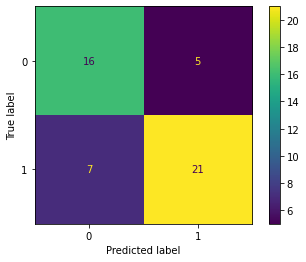

Classification Report : -
               precision    recall  f1-score   support

           0       0.70      0.76      0.73        21
           1       0.81      0.75      0.78        28

    accuracy                           0.76        49
   macro avg       0.75      0.76      0.75        49
weighted avg       0.76      0.76      0.76        49

LogisticRegression    


/Users/joaquin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(
/Users/joaquin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


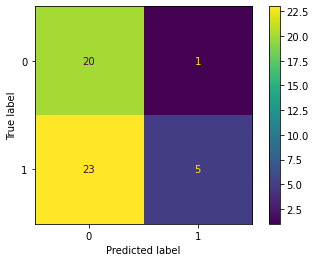

Classification Report : -
               precision    recall  f1-score   support

           0       0.47      0.95      0.62        21
           1       0.83      0.18      0.29        28

    accuracy                           0.51        49
   macro avg       0.65      0.57      0.46        49
weighted avg       0.68      0.51      0.44        49



/Users/joaquin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(
/Users/joaquin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


RandomForestClassifier


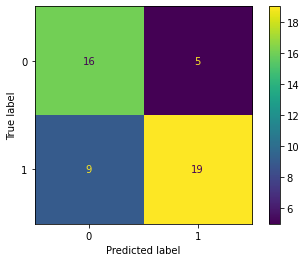

Classification Report : -
               precision    recall  f1-score   support

           0       0.64      0.76      0.70        21
           1       0.79      0.68      0.73        28

    accuracy                           0.71        49
   macro avg       0.72      0.72      0.71        49
weighted avg       0.73      0.71      0.72        49

KNeighborsClassifier  


/Users/joaquin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(


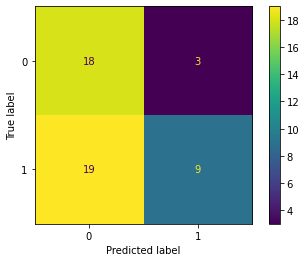

Classification Report : -
               precision    recall  f1-score   support

           0       0.49      0.86      0.62        21
           1       0.75      0.32      0.45        28

    accuracy                           0.55        49
   macro avg       0.62      0.59      0.54        49
weighted avg       0.64      0.55      0.52        49

SVC                   


/Users/joaquin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(
/Users/joaquin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


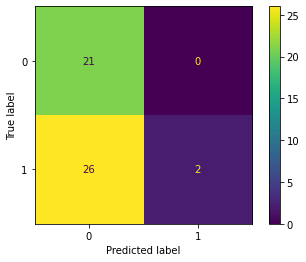

Classification Report : -
               precision    recall  f1-score   support

           0       0.45      1.00      0.62        21
           1       1.00      0.07      0.13        28

    accuracy                           0.47        49
   macro avg       0.72      0.54      0.38        49
weighted avg       0.76      0.47      0.34        49



In [32]:
list_smodels = ['DecisionTreeClassifier', 'LogisticRegression    ', 'RandomForestClassifier', 'KNeighborsClassifier  ',
                'SVC                   ']
list_models = [DecisionTreeClassifier, LogisticRegression,  RandomForestClassifier,  KNeighborsClassifier, SVC]
list_scores = ["Av. F1_train", "Accuracy", "Recall", "Precision", "F1_test"] # ,"ROC AUC Score"
pd_list = []

for (m, ms) in zip(list_models, list_smodels):
    
    if m != KNeighborsClassifier:
        model = m(random_state=42)
    else: model = m()
    pipe = Pipeline(steps = [('scale', scaler()),('model', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    pd_list.append(pd.DataFrame(data=[
                               cross_val_score(pipe,X_train ,y_train ,cv=6, scoring='f1', n_jobs=2).mean(),
                               accuracy_score(y_test, y_pred),
                               recall_score(y_test, y_pred),
                               precision_score(y_test, y_pred),
                               f1_score(y_test,y_pred)], 
                               #,roc_auc_score(y_test, y_pred)], 
                       columns=[ms],
                       index=list_scores))
    print(ms)
    cm =confusion_matrix(y_test, y_pred, normalize=None)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    namemat = ms + '.png'
    plt.savefig(namemat)
    plt.show()
    print(f"Classification Report : -\n {classification_report(y_test, y_pred)}")  
#     cross = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
#     print(cross.to_markdown())

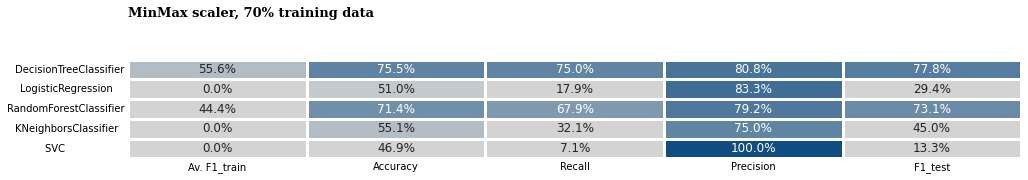

In [33]:
df_models = round(pd.concat(pd_list, axis=1),3)

colors = ["lightgray","lightgray","#0f4c81"]
colormap = clrs.LinearSegmentedColormap.from_list("", colors)


fig = plt.figure(figsize=(16, 10)) # create figure
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

sns.heatmap(df_models.T, cmap=colormap,annot=True,fmt=".1%",vmin=0,vmax=0.95, linewidths=2.5,cbar=False,ax=ax0,annot_kws={"fontsize":12})
#fig.patch.set_facecolor(background_color) # figure background color
#ax0.set_facecolor(background_color) 
ax0.text(0,-2.15,'MinMax scaler, 70% training data',fontsize=13,fontweight='bold',fontfamily='serif')
ax0.tick_params(axis=u'both', which=u'both',length=0)
plt.savefig('scores_07train_minmaxsc.png')

#### With 50 % Training Data

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)

DecisionTreeClassifier


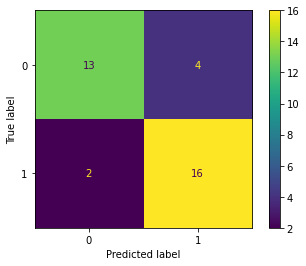

Classification Report : -
               precision    recall  f1-score   support

           0       0.87      0.76      0.81        17
           1       0.80      0.89      0.84        18

    accuracy                           0.83        35
   macro avg       0.83      0.83      0.83        35
weighted avg       0.83      0.83      0.83        35

LogisticRegression    


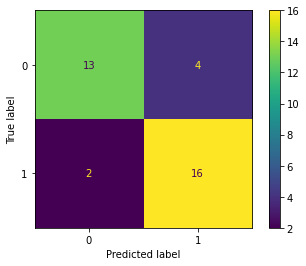

Classification Report : -
               precision    recall  f1-score   support

           0       0.87      0.76      0.81        17
           1       0.80      0.89      0.84        18

    accuracy                           0.83        35
   macro avg       0.83      0.83      0.83        35
weighted avg       0.83      0.83      0.83        35

RandomForestClassifier


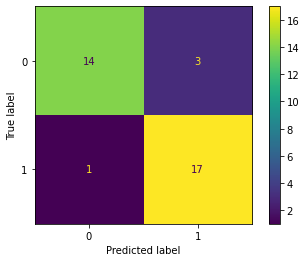

Classification Report : -
               precision    recall  f1-score   support

           0       0.93      0.82      0.87        17
           1       0.85      0.94      0.89        18

    accuracy                           0.89        35
   macro avg       0.89      0.88      0.88        35
weighted avg       0.89      0.89      0.89        35

KNeighborsClassifier  


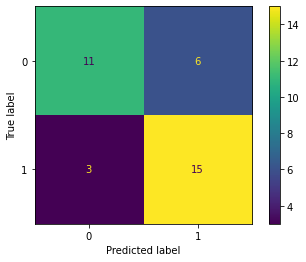

Classification Report : -
               precision    recall  f1-score   support

           0       0.79      0.65      0.71        17
           1       0.71      0.83      0.77        18

    accuracy                           0.74        35
   macro avg       0.75      0.74      0.74        35
weighted avg       0.75      0.74      0.74        35

SVC                   


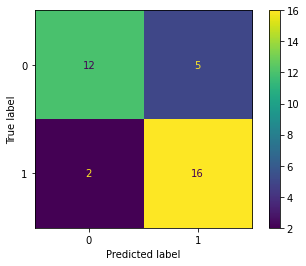

Classification Report : -
               precision    recall  f1-score   support

           0       0.86      0.71      0.77        17
           1       0.76      0.89      0.82        18

    accuracy                           0.80        35
   macro avg       0.81      0.80      0.80        35
weighted avg       0.81      0.80      0.80        35



In [35]:
pd_list = []

for (m, ms) in zip(list_models, list_smodels):
    
    if m != KNeighborsClassifier:
        model = m(random_state=42)
    else: model = m()
    pipe = Pipeline(steps = [('scale', scaler()),('model', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    pd_list.append(pd.DataFrame(data=[
                               cross_val_score(pipe,X_train ,y_train ,cv=6, scoring='f1', n_jobs=2).mean(),
                               accuracy_score(y_test, y_pred),
                               recall_score(y_test, y_pred),
                               precision_score(y_test, y_pred),
                               f1_score(y_test,y_pred)], 
                               #,roc_auc_score(y_test, y_pred)], 
                       columns=[ms],
                       index=list_scores))
    print(ms)
    cm =confusion_matrix(y_test, y_pred, normalize=None)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    namemat = ms + '.png'
    plt.savefig(namemat)
    plt.show()
    print(f"Classification Report : -\n {classification_report(y_test, y_pred)}") 

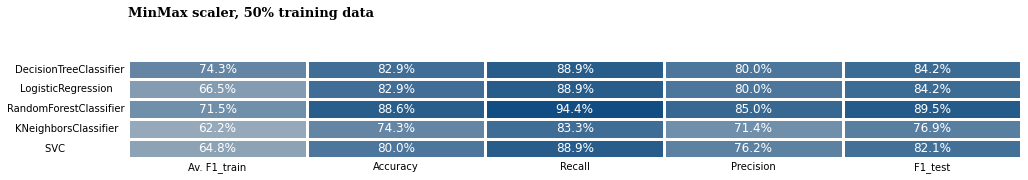

In [36]:
df_models = round(pd.concat(pd_list, axis=1),3)

colors = ["lightgray","lightgray","#0f4c81"]
colormap = clrs.LinearSegmentedColormap.from_list("", colors)


fig = plt.figure(figsize=(16, 10)) # create figure
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

sns.heatmap(df_models.T, cmap=colormap,annot=True,fmt=".1%",vmin=0,vmax=0.95, linewidths=2.5,cbar=False,ax=ax0,annot_kws={"fontsize":12})
#fig.patch.set_facecolor(background_color) # figure background color
#ax0.set_facecolor(background_color) 
ax0.text(0,-2.15,'MinMax scaler, 50% training data',fontsize=13,fontweight='bold',fontfamily='serif')
ax0.tick_params(axis=u'both', which=u'both',length=0)
plt.savefig('scores_05train_minmaxsc.png')

#### With 85 % Training Data

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.80, random_state=42)

DecisionTreeClassifier


/Users/joaquin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(


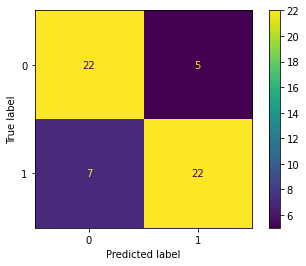

Classification Report : -
               precision    recall  f1-score   support

           0       0.76      0.81      0.79        27
           1       0.81      0.76      0.79        29

    accuracy                           0.79        56
   macro avg       0.79      0.79      0.79        56
weighted avg       0.79      0.79      0.79        56

LogisticRegression    


/Users/joaquin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/Users/joaquin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/joaquin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


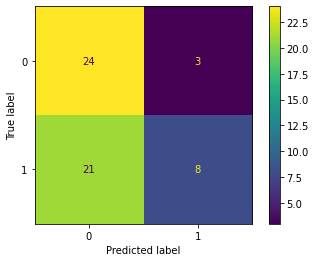

Classification Report : -
               precision    recall  f1-score   support

           0       0.53      0.89      0.67        27
           1       0.73      0.28      0.40        29

    accuracy                           0.57        56
   macro avg       0.63      0.58      0.53        56
weighted avg       0.63      0.57      0.53        56



/Users/joaquin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/Users/joaquin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/joaquin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


RandomForestClassifier


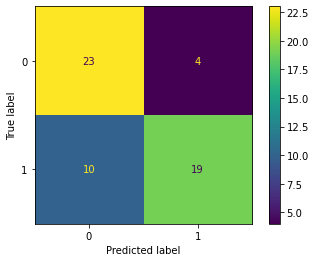

Classification Report : -
               precision    recall  f1-score   support

           0       0.70      0.85      0.77        27
           1       0.83      0.66      0.73        29

    accuracy                           0.75        56
   macro avg       0.76      0.75      0.75        56
weighted avg       0.76      0.75      0.75        56

KNeighborsClassifier  


/Users/joaquin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/Users/joaquin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


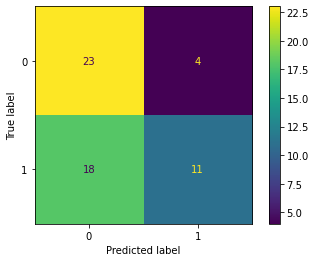

Classification Report : -
               precision    recall  f1-score   support

           0       0.56      0.85      0.68        27
           1       0.73      0.38      0.50        29

    accuracy                           0.61        56
   macro avg       0.65      0.62      0.59        56
weighted avg       0.65      0.61      0.59        56

SVC                   


/Users/joaquin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/Users/joaquin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/joaquin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


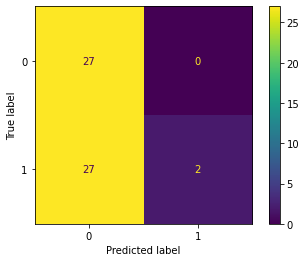

Classification Report : -
               precision    recall  f1-score   support

           0       0.50      1.00      0.67        27
           1       1.00      0.07      0.13        29

    accuracy                           0.52        56
   macro avg       0.75      0.53      0.40        56
weighted avg       0.76      0.52      0.39        56



In [38]:
pd_list = []

for (m, ms) in zip(list_models, list_smodels):
    
    if m != KNeighborsClassifier:
        model = m(random_state=42)
    else: model = m()
    pipe = Pipeline(steps = [('scale', scaler()),('model', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    pd_list.append(pd.DataFrame(data=[
                               cross_val_score(pipe,X_train ,y_train ,cv=6, scoring='f1', n_jobs=2).mean(),
                               accuracy_score(y_test, y_pred),
                               recall_score(y_test, y_pred),
                               precision_score(y_test, y_pred),
                               f1_score(y_test,y_pred)], 
                               #,roc_auc_score(y_test, y_pred)], 
                       columns=[ms],
                       index=list_scores))
    print(ms)
    cm =confusion_matrix(y_test, y_pred, normalize=None)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    namemat = ms + '.png'
    plt.savefig(namemat)
    plt.show()
    print(f"Classification Report : -\n {classification_report(y_test, y_pred)}")  

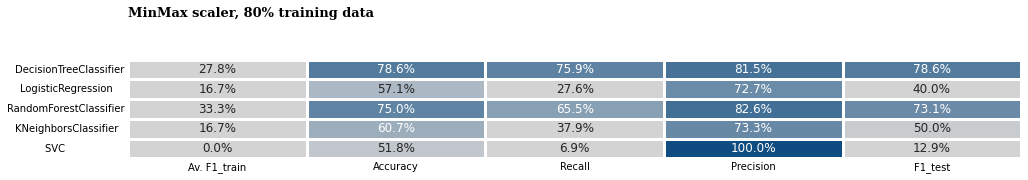

In [39]:
df_models = round(pd.concat(pd_list, axis=1),3)

colors = ["lightgray","lightgray","#0f4c81"]
colormap = clrs.LinearSegmentedColormap.from_list("", colors)


fig = plt.figure(figsize=(16, 10)) # create figure
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

sns.heatmap(df_models.T, cmap=colormap,annot=True,fmt=".1%",vmin=0,vmax=0.95, linewidths=2.5,cbar=False,ax=ax0,annot_kws={"fontsize":12})
#fig.patch.set_facecolor(background_color) # figure background color
#ax0.set_facecolor(background_color) 
ax0.text(0,-2.15,'MinMax scaler, 80% training data',fontsize=13,fontweight='bold',fontfamily='serif')
ax0.tick_params(axis=u'both', which=u'both',length=0)
plt.savefig('scores_085train_multval_minmaxsc.png')

## Selection of best model and  data training I.
According to the three tables we obtained the best model with all eleven features corresponds to Random forest classifier with 50% of data reserved for training and F1 score of 89.5 %. Its confusion matrix is:

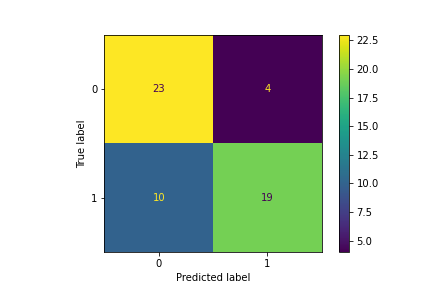

In [40]:
Image("RandomForestClassifier.png")

### Evaluate the Best Features

Use `SelectKBest` to evaluate the best features for the classifier. Here we use ANOVA (Analysis of variances) with f_classif

In [41]:
X_new = SelectKBest(f_classif, k=6).fit_transform(X, y) 
X_new[0:12, :]

array([[ 90. , 220. ,  25. ,  18. ,   1.2,   0. ],
       [ 90. , 225. ,  32. ,  16. ,   1.4,   1. ],
       [ 80. , 230. ,  40. ,   8. ,   0.8,   0. ],
       [ 70. , 240. ,  68. ,  10. ,   0.5,   1. ],
       [ 90. , 250. ,  92. ,   5. ,   0.7,   0. ],
       [ 40. , 200. ,  60. ,  24. ,   1.1,   1. ],
       [ 10. , 205. ,  55. ,  12. ,   1.3,   0. ],
       [ 10. , 210. ,  21. ,  14. ,   1.5,   1. ],
       [ 70. , 215. ,  24. ,  27. ,   1.4,   0. ],
       [ 40. , 220. ,  30. ,  25. ,   1.7,   1. ],
       [ 80. , 220. ,  75. ,  37. ,   2.4,   0. ],
       [ 20. , 225. ,  92. ,  12. ,   1.4,   1. ]])

In [42]:
X_new.shape

(69, 6)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.50, random_state=42)

DecisionTreeClassifier


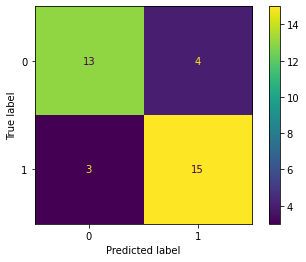

Classification Report : -
               precision    recall  f1-score   support

           0       0.81      0.76      0.79        17
           1       0.79      0.83      0.81        18

    accuracy                           0.80        35
   macro avg       0.80      0.80      0.80        35
weighted avg       0.80      0.80      0.80        35

LogisticRegression    


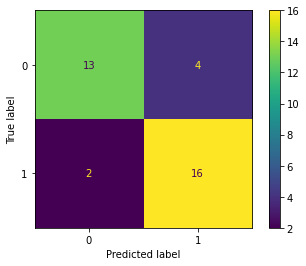

Classification Report : -
               precision    recall  f1-score   support

           0       0.87      0.76      0.81        17
           1       0.80      0.89      0.84        18

    accuracy                           0.83        35
   macro avg       0.83      0.83      0.83        35
weighted avg       0.83      0.83      0.83        35

RandomForestClassifier


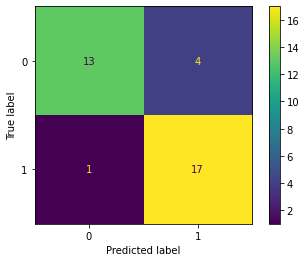

Classification Report : -
               precision    recall  f1-score   support

           0       0.93      0.76      0.84        17
           1       0.81      0.94      0.87        18

    accuracy                           0.86        35
   macro avg       0.87      0.85      0.86        35
weighted avg       0.87      0.86      0.86        35

KNeighborsClassifier  


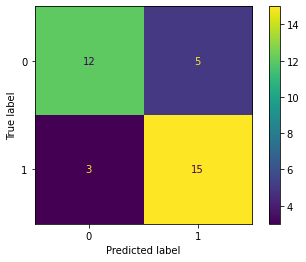

Classification Report : -
               precision    recall  f1-score   support

           0       0.80      0.71      0.75        17
           1       0.75      0.83      0.79        18

    accuracy                           0.77        35
   macro avg       0.78      0.77      0.77        35
weighted avg       0.77      0.77      0.77        35

SVC                   


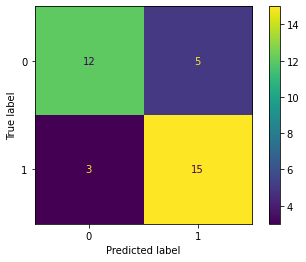

Classification Report : -
               precision    recall  f1-score   support

           0       0.80      0.71      0.75        17
           1       0.75      0.83      0.79        18

    accuracy                           0.77        35
   macro avg       0.78      0.77      0.77        35
weighted avg       0.77      0.77      0.77        35



In [44]:
pd_list = []

for (m, ms) in zip(list_models, list_smodels):
    
    if m != KNeighborsClassifier:
        model = m(random_state=42)
    else: model = m()
    pipe = Pipeline(steps = [('scale', scaler()),('model', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    pd_list.append(pd.DataFrame(data=[
                               cross_val_score(pipe,X_train ,y_train ,cv=6, scoring='f1', n_jobs=2).mean(),
                               accuracy_score(y_test, y_pred),
                               recall_score(y_test, y_pred),
                               precision_score(y_test, y_pred),
                               f1_score(y_test,y_pred)], 
                               #,roc_auc_score(y_test, y_pred)], 
                       columns=[ms],
                       index=list_scores))
    print(ms)
    cm =confusion_matrix(y_test, y_pred, normalize=None)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    namemat = ms + '6.png'
    plt.savefig(namemat)
    plt.show()
    print(f"Classification Report : -\n {classification_report(y_test, y_pred)}")  

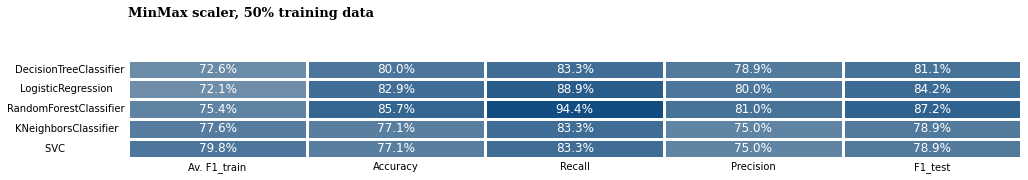

In [45]:
df_models = round(pd.concat(pd_list, axis=1),3)

colors = ["lightgray","lightgray","#0f4c81"]
colormap = clrs.LinearSegmentedColormap.from_list("", colors)


fig = plt.figure(figsize=(16, 10)) # create figure
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

sns.heatmap(df_models.T, cmap=colormap,annot=True,fmt=".1%",vmin=0,vmax=0.95, linewidths=2.5,cbar=False,ax=ax0,annot_kws={"fontsize":12})
#fig.patch.set_facecolor(background_color) # figure background color
#ax0.set_facecolor(background_color) 
ax0.text(0,-2.15,'MinMax scaler, 50% training data',fontsize=13,fontweight='bold',fontfamily='serif')
ax0.tick_params(axis=u'both', which=u'both',length=0)
plt.savefig('scores_05train_6features_minmaxsc.png')

Here we noticed that if we take with six features instead of eleven features, as suggested ANOVA, the random forest classifier still the bes model, but with a slight reduction to 87.2 % of F1 score.

## Part 3: Regression

Develop a regression model to predict Tension Strength (MPa). Compare predicted PLS and ABS tension strength with the regression model.

### Scale Data

Scale `data` with `StandardScaler` or `MinMaxScaler`. 

In [46]:
#scaler  = MinMaxScaler
scaler = StandardScaler
#scaler = RobustScaler #(quantile_range=(25, 75)).fit_transform(X)

### Select Input Features (X) and Output Label (y)

Using the 9 machine settings as the input features.

- Layer Height (mm)
- Wall Thickness (mm)
- Infill Density (%)
- Infill Pattern (Honeycomb or Grid)
- Nozzle Temperature (ºC)
- Bed Temperature (ºC)
- Print Speed (mm/s)
- Material (PLA or ABS)
- Fan Speed (%)

The output label is the `tension_strength`.

- Tension Strength (MPa)

Divide the data into sets that contain the input features (X) and output label (y=`tension_strength`). Save data feature columns with `X_names=list(data.columns)[0:9]`.

In [47]:
df0.columns

Index(['layer_height', 'wall_thickness', 'infill_density',
       'nozzle_temperature', 'bed_temperature', 'print_speed', 'fan_speed',
       'roughness', 'tension_strength', 'elongation', 'material_label',
       'infill_pattern_label'],
      dtype='object')

In [48]:
features = ['layer_height', 'wall_thickness', 'infill_density',
       'nozzle_temperature', 'bed_temperature', 'print_speed', 'fan_speed',
        'material_label', 'infill_pattern_label']
X = df0[features]
y = df0[['tension_strength']]
X = X.to_numpy()
y = y.to_numpy()
print("X shape", X.shape)
print("y shape", y.shape)
#y = y.reshape(-1, 1)
y = np.ravel(y,order="c")
print("y2 shape", y.shape)
print(y[0:8])

X shape (69, 9)
y shape (69, 1)
y2 shape (69,)
[18 16  8 10  5 24 12 14]


In [49]:
X[0:10]

array([[2.00e-02, 8.00e+00, 9.00e+01, 2.20e+02, 6.00e+01, 4.00e+01,
        0.00e+00, 0.00e+00, 0.00e+00],
       [2.00e-02, 7.00e+00, 9.00e+01, 2.25e+02, 6.50e+01, 4.00e+01,
        2.50e+01, 0.00e+00, 1.00e+00],
       [2.00e-02, 1.00e+00, 8.00e+01, 2.30e+02, 7.00e+01, 4.00e+01,
        5.00e+01, 0.00e+00, 0.00e+00],
       [2.00e-02, 4.00e+00, 7.00e+01, 2.40e+02, 7.50e+01, 4.00e+01,
        7.50e+01, 0.00e+00, 1.00e+00],
       [2.00e-02, 6.00e+00, 9.00e+01, 2.50e+02, 8.00e+01, 4.00e+01,
        1.00e+02, 0.00e+00, 0.00e+00],
       [2.00e-02, 1.00e+01, 4.00e+01, 2.00e+02, 6.00e+01, 4.00e+01,
        0.00e+00, 1.00e+00, 1.00e+00],
       [2.00e-02, 5.00e+00, 1.00e+01, 2.05e+02, 6.50e+01, 4.00e+01,
        2.50e+01, 1.00e+00, 0.00e+00],
       [2.00e-02, 1.00e+01, 1.00e+01, 2.10e+02, 7.00e+01, 4.00e+01,
        5.00e+01, 1.00e+00, 1.00e+00],
       [2.00e-02, 9.00e+00, 7.00e+01, 2.15e+02, 7.50e+01, 4.00e+01,
        7.50e+01, 1.00e+00, 0.00e+00],
       [2.00e-02, 8.00e+00, 4.00e+01,

### Split Data

Randomly select values that split the data into a train (50%) and test (50%) set, and for a second set the data are split into a train (65%) and test (45%)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.50, random_state=42)

### Regression Fit

Use 3 regression methods. Use Linear Regression, Neural Network (Deep Learning), and another regression method of your choice. Discuss the performance of each. Possible regression methods are:

- Linear Regression
- Logistic Regression
- K-Nearest Neighbors
- Support Vector Regressor

In [51]:
scaler = StandardScaler
list_smodels = ['LinearRegression' , 'LinearLogistic',  'KNeighborsRegressor  ','SVR                   ']
list_models = [LogisticRegression, LinearRegression, KNeighborsRegressor, SVR]
list_scores = ["CVS r2", "r2_score", "mean_squared_error"] # ,"ROC AUC Score"
pd_list = []
y_predlist = []
for (m, ms) in zip(list_models, list_smodels):
    
    model = m()
    pipe = Pipeline(steps = [('scale', scaler()),('model', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_predlist.append(y_pred)
    pd_list.append(pd.DataFrame(data=[cross_val_score(pipe,X_train ,y_train ,cv=4, scoring='r2', n_jobs=2).mean(),
                                      r2_score(y_test, y_pred),
                                      mean_squared_error(y_test, y_pred)], 
                       columns=[ms],
                       index=list_scores))      
#    print(ms)
pd_list

/Users/joaquin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


[                    LinearRegression
 CVS r2                      0.523628
 r2_score                    0.705823
 mean_squared_error         24.942857,
                     LinearLogistic
 CVS r2                1.000000e+00
 r2_score              1.000000e+00
 mean_squared_error    1.027773e-29,
                     KNeighborsRegressor  
 CVS r2                           0.737358
 r2_score                         0.852379
 mean_squared_error              12.516571,
                     SVR                   
 CVS r2                            0.201428
 r2_score                          0.442273
 mean_squared_error               47.288841]

In [52]:
y_test2plot = y_test
y_pred2plot = y_predlist

In [53]:
scaler  = MinMaxScaler
list_smodels = ['LinearRegression' , 'LinearLogistic',  'KNeighborsRegressor  ','SVR                   ']
list_models = [LogisticRegression, LinearRegression, KNeighborsRegressor, SVR]
list_scores = ["CVS r2", "r2_score", "mean_squared_error"] # ,"ROC AUC Score"
pd_list = []

for (m, ms) in zip(list_models, list_smodels):
    
    model = m()
    pipe = Pipeline(steps = [('scale', scaler()),('model', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    pd_list.append(pd.DataFrame(data=[cross_val_score(pipe,X_train ,y_train ,cv=4, scoring='r2', n_jobs=2).mean(),
                                      r2_score(y_test, y_pred),
                                      mean_squared_error(y_test, y_pred)], 
                       columns=[ms],
                       index=list_scores))      
#    print(ms)
pd_list

/Users/joaquin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


[                    LinearRegression
 CVS r2                      0.099716
 r2_score                    0.401200
 mean_squared_error         50.771429,
                     LinearLogistic
 CVS r2                1.000000e+00
 r2_score              1.000000e+00
 mean_squared_error    2.936816e-29,
                     KNeighborsRegressor  
 CVS r2                           0.505805
 r2_score                         0.745801
 mean_squared_error              21.553143,
                     SVR                   
 CVS r2                            0.167390
 r2_score                          0.374699
 mean_squared_error               53.018411]

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.65, random_state=42)

pd_list = []

for (m, ms) in zip(list_models, list_smodels):
    
    model = m()
    pipe = Pipeline(steps = [('scale', scaler()),('model', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    pd_list.append(pd.DataFrame(data=[cross_val_score(pipe,X_train ,y_train ,cv=4, scoring='r2', n_jobs=2).mean(),
                                      r2_score(y_test, y_pred),
                                      mean_squared_error(y_test, y_pred)], 
                       columns=[ms],
                       index=list_scores))      
#    print(ms)
pd_list

/Users/joaquin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


[                    LinearRegression
 CVS r2                     -0.002813
 r2_score                   -0.249051
 mean_squared_error        108.822222,
                     LinearLogistic
 CVS r2                1.000000e+00
 r2_score              1.000000e+00
 mean_squared_error    3.460470e-29,
                     KNeighborsRegressor  
 CVS r2                           0.596342
 r2_score                         0.613179
 mean_squared_error              33.701333,
                     SVR                   
 CVS r2                            0.150464
 r2_score                          0.166498
 mean_squared_error               72.618029]

### Validation

Report the correlation coefficient ($R^2$) for the train and test sets.

From the previous tables, we conclude that the Linear Logistic and K Neighbors Regressor are the best models with standar scaler and 50 training, since the latter  obtained the closest score to 1 while the former got a perfect score. On the contrary the Linear Regressor shows a very bad performance with even negative values for the 65 % of training and MinMax scaler.

### Parity Plot

A parity plot is a scatter plot with predicted versus measured. A parity plot of the training and test data is a good way to see the overall fit of tension strength. Here we see that in the Linear Logistic model, the points are perfectly aligned along a 45 degree, while the K Neighbors Regressor has substantial deviations.

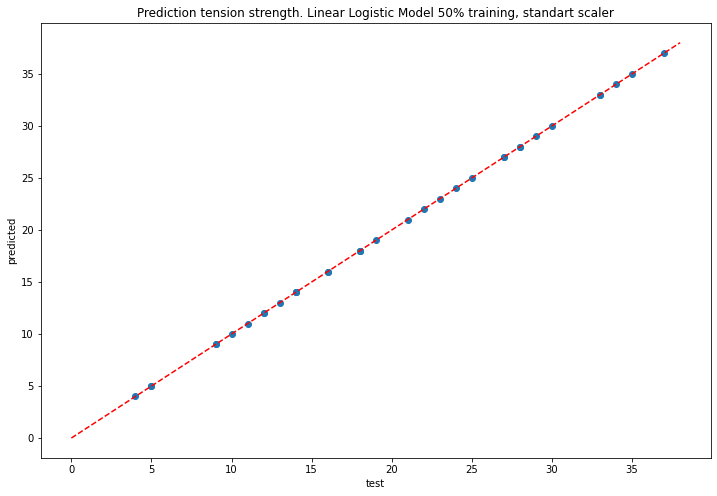

In [55]:
x = np.arange(0,39)
plt.figure(figsize=(12, 8))
plt.xlabel("test")
plt.ylabel("predicted")
plt.scatter(y_test2plot, y_pred2plot[1] )
plt.title('Prediction tension strength. Linear Logistic Model 50% training, standart scaler')
plt.plot(x,x, 'r--')
plt.show()

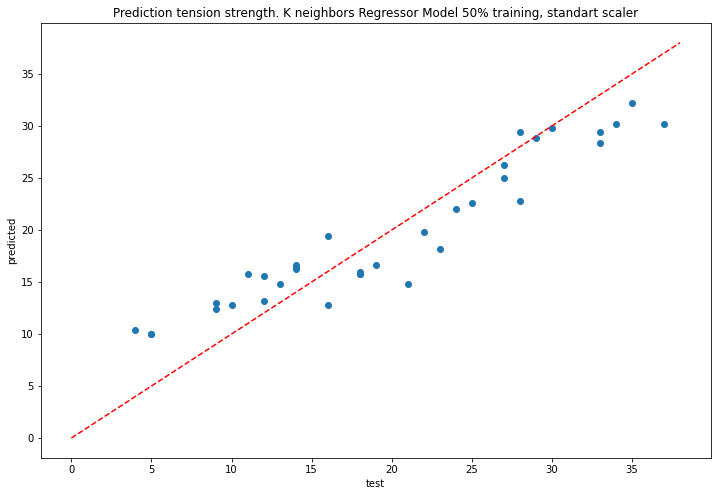

In [56]:
plt.figure(figsize=(12, 8))
plt.xlabel("test")
plt.ylabel("predicted")
plt.scatter(y_test2plot, y_pred2plot[2] )
plt.title('Prediction tension strength. K neighbors Regressor Model 50% training, standart scaler')
plt.plot(x,x, 'r--')
plt.show()